# Analysis of SHEMAT-Suite models

The created geological models with gempy were exported as SHEMAT-Suite input files. SHEMAT-Suite (https://git.rwth-aachen.de/SHEMAT-Suite/SHEMAT-Suite-open) [1] is a code for solving coupled heat transport in porous media. It is written in fortran and uses a finite differences scheme in a hexahedral grid.

In this example, we will load a heat transport simulation from the base POC model we created in "Geological model creation and gravity simulation". We will demonstrate methods contained in OpenWF for loading the result file, displaying the parameters it contains and how to visualize these parameters. Finally, we will calculate the conductive heat flow and plot it.

In [1]:
# import some libraries
from scipy.stats import hmean
import pandas as pd
import numpy as np
import glob
import h5py
import os, sys
sys.path.append('../../')
import OpenWF.postprocessing as pp

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')

Simulation results from SHEMAT-Suite can be written in different file formats, such as VTK (Visualization Toolkit) HDF5 (Hierarchical Data Format), or PLT (TecPlot). In addition, optional outputs, such as ASCII-Files with comparison of simulated values to measured ones can be provided. Further, a status log of the simulation and other meta-files. A full coverage of possible output files is provided in the SHEMAT-Suite wiki ( https://git.rwth-aachen.de/SHEMAT-Suite/SHEMAT-Suite-open/-/wikis/home). 
In this tutorial, we will work with HDF5 files and VTK files. The majority of methods in OpenWF are tailored towards HDF5 files, which are smaller than their VTK relatives.

However, there exists a powerful visualization code for python which builds upon vtk, called pyvista. We will briefly showcase its capabilities at the end of this tutorial.

## Load HDF5 file
From the base POC model, we created a SHEMAT-Suite input file. This was then executed with the compiled SHEMAT-Suite code. As basic information: we look at conductive heat transport, i.e. no fluid flow, and heat transport is described by Fourier's law of heat conduction $q = - \lambda \nabla T$. At the base of the model, the heat flow boundary condition is set to 72 mW/m$^2$.

OpenWF has a built in method for loading HDF5 files, though reading a file is a one-liner using the library ``h5py``. 
```python 
fid = h5py.File('../../models/SHEMAT-Suite_output/SHEMAT_PCT_base_model_final.h5')
```
The file can be loaded in different states, among others for 'r' for read, 'a' for append, 'w' for write, etc. The ``read_hdf`` method in OpenWF lets the user also choose the state to load the HDF5 file.

In [2]:
model_path = '../../models/SHEMAT-Suite_output/SHEMAT_PCT_base_model_temp_final.h5'
fid = pp.read_hdf_file(model_path, write=False)

To check the parameters stored in the HDF5 file, you can query the loaded h5py file for its keys, i.e. the "labels" of the data boxes stored in the HDF5 file.

In [3]:
fid.keys()

<KeysViewHDF5 ['comp', 'delx', 'dely', 'delz', 'df', 'ec', 'head', 'itemp_bcd', 'itemp_bcn', 'kx', 'ky', 'kz', 'lc', 'lx', 'ly', 'lz', 'por', 'pres', 'q', 'rc', 'rhof', 'temp', 'temp_bcd', 'temp_bcn', 'uindex', 'visf', 'vx', 'vy', 'vz', 'x', 'y', 'z']>

As some of these acronyms can have no meaning to new users, we implemented a method, specifically for SHEMAT-Suite generated HDF5 files to present information about the stored parameters:

In [4]:
pp.available_parameters(fid)

{'comp': 'compressibility',
 'delx': 'discretization in x direction in meter',
 'dely': 'discretization in y direction in meter',
 'delz': 'discretization in z direction in meter',
 'df': '?',
 'ec': '?',
 'head': 'hydraulic potential in meter',
 'itemp_bcd': '?',
 'itemp_bcn': '?',
 'kx': 'log-permeability (square meter) in x direction',
 'ky': 'log-permeability (square meter) in y direction',
 'kz': 'log-permeability (square meter) in z direction',
 'lc': '?',
 'lx': 'thermal conductivity in x direction in watt per meter and kelvin',
 'ly': 'thermal conductivity in y direction in watt per meter and kelvin',
 'lz': 'thermal conductivity in z direction in watt per meter and kelvin',
 'por': 'porosity',
 'pres': 'pressure in megapascal',
 'q': '?',
 'rc': '?',
 'rhof': 'density water in kilogram per cubic meter',
 'temp': 'temperature in degrees celsius',
 'temp_bcd': 'temperature dirichlet boundary condition in degrees celsius',
 'temp_bcn': 'temperature neumann boundary condition in d

The postprocessing in OpenWF has methods for quickly displaying the parameters in each of the model dimensions in a 2D slice. For instance, we will look at a profile through the model parallel to the y direction, thus showing a crosssection of the model. In lines, it shows the interfaces between different geological units, and the specified parameter as a colored contour field. 

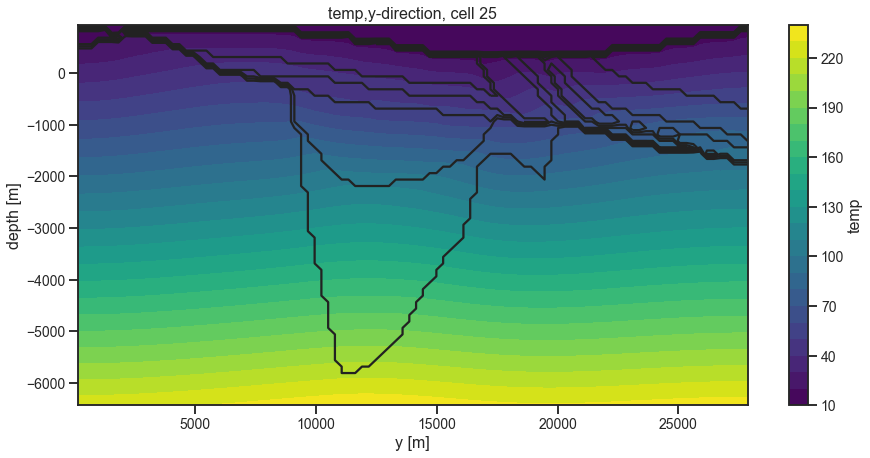

In [5]:
# plot slice temperature
fig = plt.figure(figsize=[15,7])
pp.plot_slice(model_path, parameter='temp', direction='y', cell_number=25, model_depth=6500.)

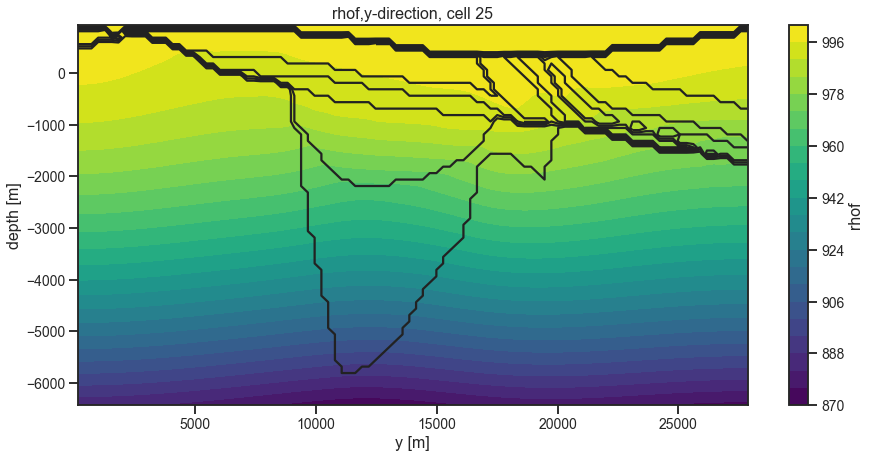

In [6]:
# plot slice fluid density
fig = plt.figure(figsize=[15,7])
pp.plot_slice(model_path, parameter='rhof', direction='y', cell_number=25, model_depth=6500)

## Heat flow estimation
SHEMAT-Suite does not provide the heat flow for HDF5 files. It does, however, store it in the vtk output. To also have the heat flow for HDF5 files, we provide a method for calculating it. In the future, it may be directly written in HDF5 files by SHEMAT-Suite. The method calculates the conductive heat flow in all model dimensions per default. The user can specify, if only one direction should be yielded by the method.

In [7]:
qx, qy, qz = pp.calc_cond_hf(fid)
print(qz.shape)

(60, 50, 100)


Maybe here is a good point to talk about the dimensions and according directions in the HDF5 file. We see above, that qz has three dimensions, one with 60 entries, one with 50 entries, and one with 100 entries. These is also the cell discretization in z, y, and x direction. That is, in an HDF5 file from SHEMAT-Suite, we have the dimensions [z,y,x], so here qz[z,y,x]. 

The three variables now contain the heat flow in x, y, z direction for each cell in the model. Let's have a look at a horizontal slice through the model center and the heat flow in z-direction. Remembering the notation for directions, and seeing that in z-direction, we have 60 cells, the horizontal slice would reflect ``qz[29,:,:]``, i.e. all entries in x- and y-direction at index 29 of the z-direction. In the HDF5-file, we further count from the bottom, so ``qz[0,:,:]`` is the deepest slice, ``qz[-1,:,:]`` the shallowest.

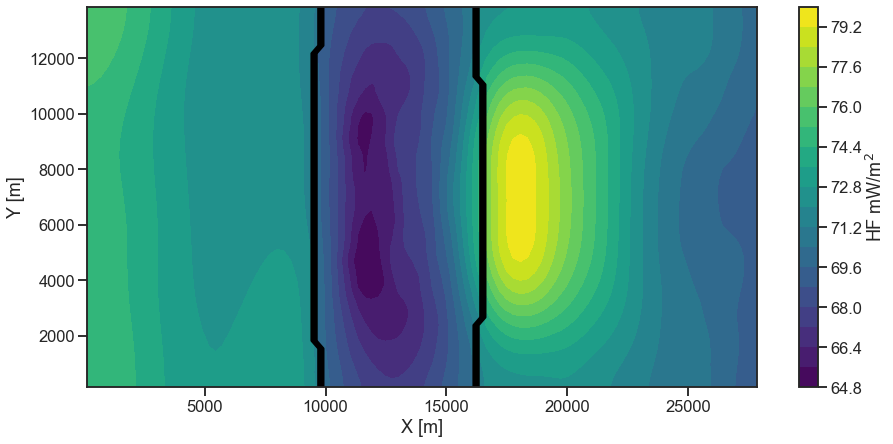

In [8]:
# Get the model dimensions in x, y, z
x = fid['x'][0,0,:]
y = fid['y'][0,:,0]
z = fid['z'][:,0,0]

cell_number = 29
ui_cs = fid['uindex'][cell_number,:,:]

fig = plt.figure(figsize=[15,7])
cs = plt.contourf(x,y,qz[cell_number]*1000, 20, cmap='viridis')
plt.contour(x,y,ui_cs, colors='k')
plt.colorbar(cs, label='HF mW/m$^2$')
plt.xlabel('X [m]')
plt.ylabel('Y [m]');

Next to calculating the heatflow in each cell, we implemented a method to calculate it over a specified interval, e.g. over the depth interval of -4000 m to -3000 m, so providing the average heat flow over this depth interval.

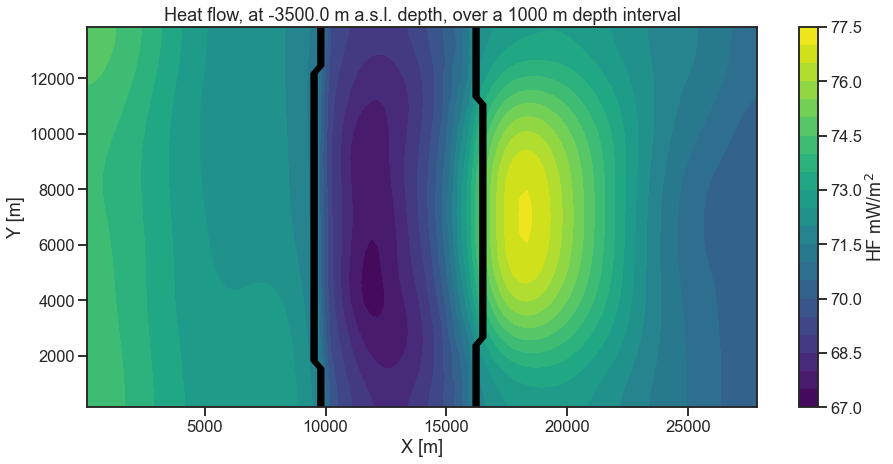

In [9]:
deeper = -4000
shallower = -3000
mid_depth = deeper - (deeper - shallower) / 2

qz_int = pp.calc_cond_hf_over_interval(fid, depth_interval=[deeper,shallower], model_depth=6500)

fig = plt.figure(figsize=[15,7])
cs = plt.contourf(x,y,qz_int*1000, 20, cmap='viridis')
plt.contour(x,y,ui_cs, colors='k')
plt.colorbar(cs, label='HF mW/m$^2$')
plt.title(f"Heat flow, at {mid_depth} m a.s.l. depth, over a {np.abs(deeper-shallower)} m depth interval")
plt.xlabel('X [m]')
plt.ylabel('Y [m]');

## VTK and pyvista
Pyvista ( https://docs.pyvista.org/ ) is a python library for working with 3D meshes and providing an interface for VTK files.

In [31]:
import pyvista as pv
pv.set_plot_theme("document")

simulation = pv.read('../../models/SHEMAT-Suite_output/SHEMAT_PCT_base_model_temp_final.vtk')

This line loads the VTK file. For information about its content, we can simply call the variable:

In [32]:
simulation

RectilinearGrid (0x24e5ca1ab80)
  N Cells:	286209
  N Points:	300000
  X Bounds:	1.400e+02, 2.786e+04
  Y Bounds:	1.400e+02, 1.386e+04
  Z Bounds:	6.250e+01, 7.438e+03
  Dimensions:	100, 50, 60
  N Arrays:	8

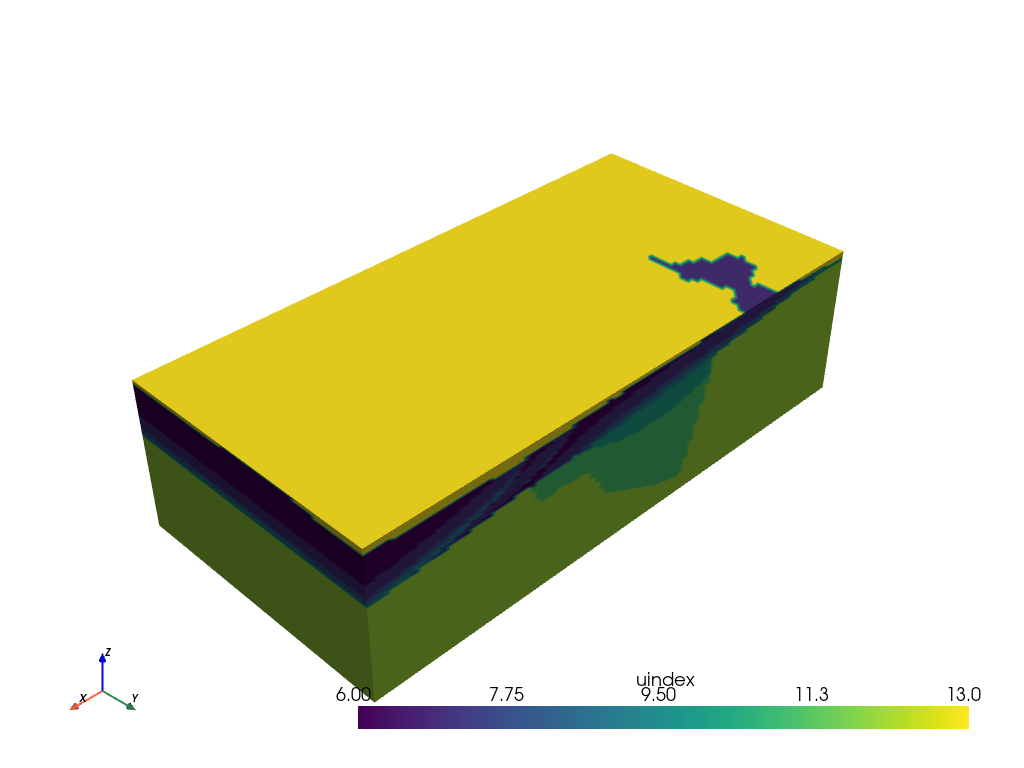

In [33]:
simulation.plot();

The vtk file has a couple of scalar values stored (seen in the table with data arrays). We can switch the active scalars to temperature for example using:

In [34]:
simulation.set_active_scalars('temp')

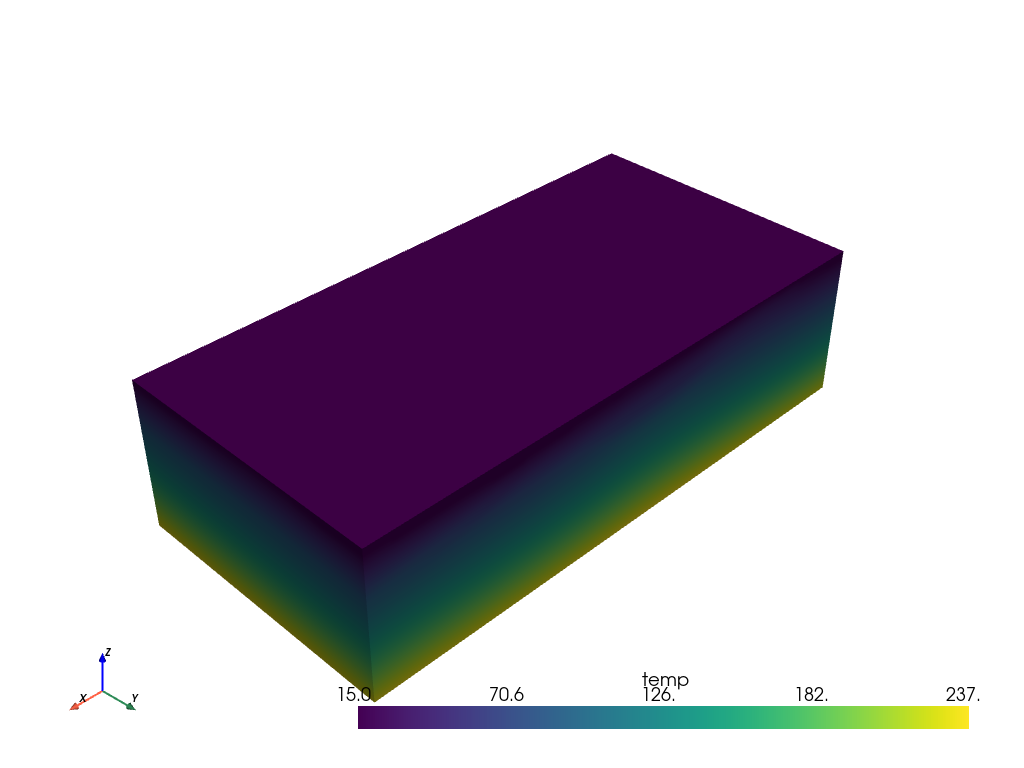

In [35]:
simulation.plot();